In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd

HydroSHEDS (Hydrological data and maps based on SHuttle Elevation Derivatives at multiple Scales) provides hydrographic information in a consistent and comprehensive format for regional and global-scale applications. HydroSHEDS offers a suite of geo-referenced data sets in raster and vector format, including stream networks, watershed boundaries, drainage directions, and ancillary data layers such as flow accumulations, distances, and river topology information.

The homepage http://www.hydrosheds.org/page/overview allows users to register and download shapefiles of river basins of the world. Particularly the Mekong Basin can be found from Asia region, at level 3.

In [2]:
mekong_basin_file = '../shapefiles/hybas_as_lev03_v1c/hybas_as_lev03_v1c.shp'

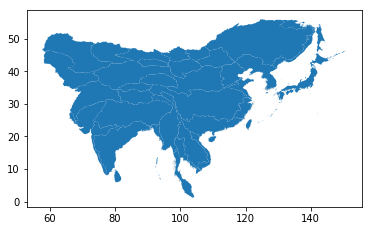

In [3]:
df = gpd.read_file(mekong_basin_file)
df.plot();

The Mekong Basin comprises of the higher basin and the lower basin. The higher part completely belongs to China teritory while the lower speards over Myanmar, Thailand, Laos, Cambodia, and Viet Nam.

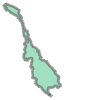

In [4]:
# Mekong Basin has the index 11 in the HYBAS_ID
mekong_basin_id = 4030017020
df.set_index('HYBAS_ID').loc[mekong_basin_id].geometry

The following class defines the modis  grid. This is useful to find which MODIS tiles cover a geometry object. In the following we use Modis Grid object to find related tiles covering the Mekong Basin region.

In [5]:
import fiona
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping
    
class ModisGrid(object):       
      
    def __init__(self, shapefile): 
    
        self.grid = {}         
        with fiona.open(shapefile, 'r') as source:
            for f in source:
                coord = 'h%02dv%02d' % (f['properties']['h'], f['properties']['v'])
                self.grid[coord] = shape(f['geometry'])
            self.crs = source.crs           

    def intersects(self, geom, crs):

        tiles = []
        if not isinstance(geom, dict):  
            geom = mapping(geom)            
        geom = shape(transform_geom(crs, self.crs, geom))
        for coord, cell in self.grid.items():
            if cell.intersects(geom):       
                tiles.append(coord)             
        return tiles

In [6]:
modis_grid_file = '../shapefiles/modis_grid/modis_sinusoidal_grid_world.shp'

In [7]:
modis_grid = ModisGrid(modis_grid_file)

In [8]:
mekong_basin_shape = df.set_index('HYBAS_ID').loc[mekong_basin_id].geometry
tiles = modis_grid.intersects(mekong_basin_shape, df.crs)

These tiles can be download from https://search.earthdata.nasa.gov/

In [9]:
print(tiles)

['h28v08', 'h27v07', 'h28v07', 'h26v06', 'h27v06', 'h25v05', 'h26v05']


Alternatively we can export the geometry into a GeoJSON format file, and use it as the input to search for relevant MODIS tiles.

In [21]:
subdf = df[df.HYBAS_ID == mekong_basin_id]
subdf.to_file('../shapefiles/mekong_basin.geojson', driver='GeoJSON')

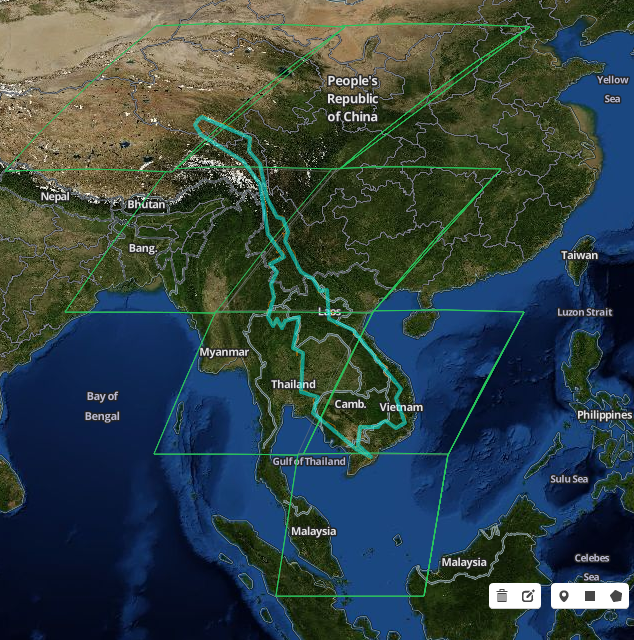

In [22]:
from IPython.display import Image
Image(filename="../shapefiles/mekong_basin.png")